In [2]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from numpy.fft import fft, fftfreq, fftshift


In [3]:
def Codage_canal(B, G):
    B = np.append(B, np.zeros(len(G) - 1, dtype=int)) 
    for j in range(len(B) - len(G) + 1):
        if B[j] == 1:
            B[j:j+len(G)] ^= G  # Div binaire
    return np.append(B[:len(B)-(len(G)-1)], B[-(len(G)-1):])  


In [4]:
def Modulation(Seq):
    Seq = Seq.reshape(-1, 3)  # regroupement par blocs de 3 bits
    decimal = Seq[:, 0] * 4 + Seq[:, 1] * 2 + Seq[:, 2]  # conversion  en décimal 
    angles = 2 * np.pi * decimal / 8  
    #un nombre complexe de module 1
    return np.exp(1j * angles)  


In [5]:
def Demodulation(signal):
    #recp du phase des symboles 
    angles = np.angle(signal)
    angles[angles < 0] += 2 * np.pi  # verification du l'angle
    symbols = np.round(angles * 8 / (2 * np.pi)) % 8
    symbols = symbols.astype(int)  
    #converssion des sym en bit
    bits = np.array([[(s >> 2) & 1, (s >> 1) & 1, s & 1] for s in symbols], dtype=int)
    return bits.flatten()


In [24]:
def Canal_Rayleigh(signal, N, SNR_dB):
    rng = default_rng()
    delays = np.random.randint(0, 10, size=N)  # ceration du retards random
    h = (rng.normal(size=N) + 1j * rng.normal(size=N)) / np.sqrt(2*N)  # coeff Rayleigh
    # Construction du canal dans le temps
    h_signal = np.zeros(max(delays) + 1, dtype=complex)
    for i in range(N):
        h_signal[delays[i]] += h[i] 
    signal_received = lfilter(h_signal, [1.0], signal)  

    signal_power = np.mean(np.abs(signal)**2)  #On élève le module au carré, ce qui donne la puissance instantanée de chaque échantillon 
    SNR_linear = 10 ** (SNR_dB / 10)
    noise_power = signal_power / SNR_linear
    #gen bruit and add it 
    noise = np.sqrt(noise_power / 2) * (rng.normal(size=len(signal_received)) + 1j * rng.normal(size=len(signal_received)))

    return signal_received + noise, h_signal


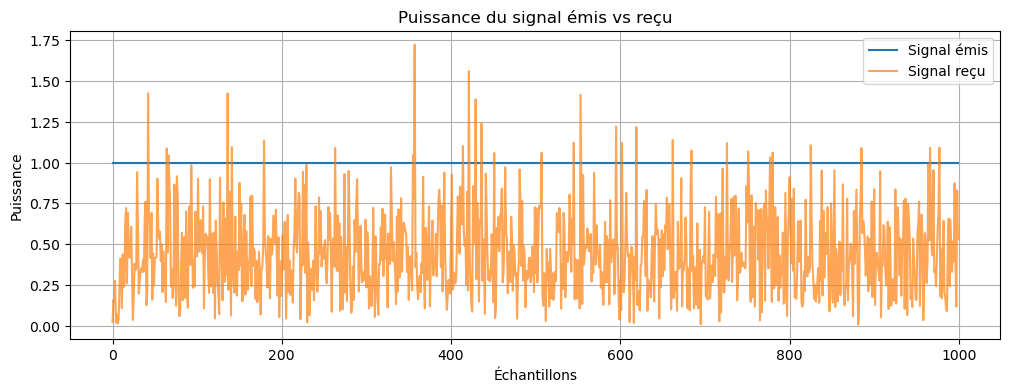

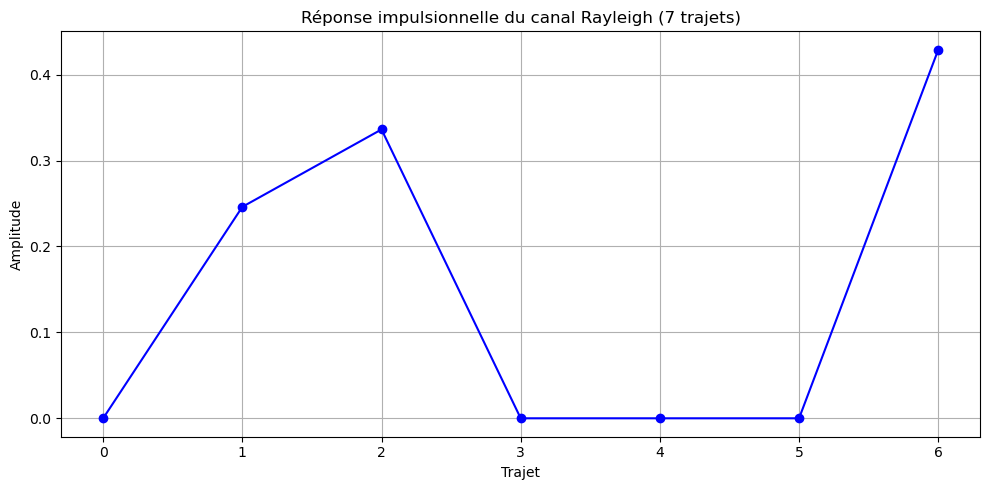

Taux d'erreur binaire (BER) : 0.32354


In [26]:
def main():
    # Générer un message binaire de 10000 bits
    rng = default_rng()
    B = rng.integers(0, 2, 10000)

    # Effectuer un codage canal polynomial par le polynôme générateur x^5+x^3 + x + 1
    G = np.array([1,0,1,0,1,1])
    coded = Codage_canal(B, G)

    # Appliquer une modulation 8-PSK à la séquence codée
    padded_len = len(coded) + (-len(coded) % 3)
    coded = np.pad(coded, (0, padded_len - len(coded)), constant_values=0)
    modulated = Modulation(coded.reshape(-1, 3))

    # Appliquer au signal porteur obtenu un canal multi-trajets de 7 trajets avec SNR=11dB 
    received, h = Canal_Rayleigh(modulated, 7, 11)

    #  Afficher dans une même figure la puissance du signal émis et celle du signal reçu.
    plt.figure(figsize=(12, 4))
    plt.plot(np.abs(modulated[:1000])**2, label='Signal émis')
    plt.plot(np.abs(received[:1000])**2, label='Signal reçu', alpha=0.7)
    plt.legend()
    plt.title("Puissance du signal émis vs reçu")
    plt.xlabel("Échantillons")
    plt.ylabel("Puissance")
    plt.grid(True)
    plt.show()

    #Afficher dans une deuxième figure une courbe indiquant la réponse du canal.


    plt.figure(figsize=(10, 5))
    plt.plot(range(7), np.abs(h[:7]), marker='o', linestyle='-', color='b')
    plt.title("Réponse impulsionnelle du canal Rayleigh (7 trajets)")
    plt.xlabel("Trajet")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Démodulation
    demodulated_bits = Demodulation(received)

    # Taux d'erreur binaire
    bits_coded = coded[:len(demodulated_bits)]
    BER = np.sum(bits_coded != demodulated_bits) / len(bits_coded)
    print(f"Taux d'erreur binaire (BER) : {BER:.5f}")

if __name__ == "__main__":
    main()
